# FEATURE-ENHANCED NEURAL NETWORK FOR MOVIE RECOMMENDATIONS

---

**Executive Summary**

This project implements a **Feature-Enhanced Neural Network** for movie recommendation systems using the MovieLens-1M dataset. The model leverages deep learning to combine user demographics and movie content features, providing personalized recommendations with negative sampling and temporal validation. 

**Key Implementation Features**
- **Feature-Enhanced Architecture**: Combines user demographics with movie content features
- **Temporal Validation**: Uses proper time-based splits to simulate realistic evaluation scenarios  
- **Cold Start Implementation**: Provides recommendations for new users using demographic information
- **Training Infrastructure**: Includes early stopping, model checkpointing, and comprehensive metrics tracking

---

**System Architecture**

- Feature Engineering (left): `User Demographics` and `Movie Metadata` are ingested by the `Feature Processor`, producing two fixed-size vectors: `User Features` with 29 dimensions and `Movie Features` with 768 dimensions. These sizes correspond to the notebook outputs `user_feature_dim=29` and `movie_feature_dim=768`.
- Model Architecture (bottom): User features pass through fully connected layers 128→64; movie features pass through 256→128→64. The two 64‑D embeddings are concatenated and fed to a deep network 128→64→32→1 with a sigmoid output for binary relevance.
- Data Pipeline (right): `MovieLens‑1M Dataset` → `Data Preprocessing` → `Temporal Split`, branching into `Training Set`, `Validation Set`, and `Test Set` following the rank‑based split: training uses all but the last two interactions per user, validation uses the penultimate, and test uses the latest.

![System Architecture](images/archictecture.png)


---

**Dataset Overview**

**MovieLens-1M Dataset**
- **1,000,209 ratings** from 6,040 users on 3,900 movies
- **User Demographics**: Age, gender, occupation, zip code
- **Movie Metadata**: Title, genres, release year  
- **Rating Scale**: 1-5 stars (converted to binary: 4-5 = positive)

**Data Split Strategy**
- All user interactions are sorted by timestamp and split per user: `Training` contains all ratings except the last two, `Validation` contains the penultimate rating, and `Test` contains the most recent rating. This prevents temporal leakage and matches the rank‑based implementation in the notebook (`rank_latest` with 1=latest, 2=penultimate).

<img src="images/split_strategy.png" width="550">

---

**Model Architecture Details**

**Feature Processing Pipeline**
- User side: demographics are encoded into embeddings and passed through fully connected layers 128→64. The output is a 64‑D user representation.
- Movie side: title embeddings (768‑D) plus one‑hot genres are processed through 256→128→64 layers, yielding a 64‑D movie representation.
- Fusion: the two 64‑D vectors are concatenated and fed to a downstream MLP 128→64→32→1 with sigmoid, aligning with the binary target used in this notebook.

![Model Archictecture](images/model_archictecture.png)


---

**Expected Outcomes**

**Performance Metrics**
- **Hit Ratio @ 10**: Percentage of users with relevant items in top-10 recommendations
- **Mean Reciprocal Rank (MRR)**: Average reciprocal rank of the first relevant item
- **Mean Rank**: Average position of relevant items in recommendation lists

---

## IMPORTS

This section we imports the necessary libraries and variables to run the notebook.

### Libraries

In [176]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import torch 

from tqdm.notebook import tqdm
from ncf_trainer import NCFTrainer
from feature_processor import FeatureProcessor

from candidate_generator import CandidateGenerator
from validate_model import validate_model_with_features
from ncf import NCF
from cold_start import ColdStartRecommender

np.random.seed(123)

os.environ["TOKENIZERS_PARALLELISM"] = "false"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Control Variables

In [157]:
SAMPLE=False
NUM_EPOCHS = 100
DEBUG=False

---

## TRAINING  

This section we show all the process of the traning pipeline, from the training strategy, dataset loading untill the model optimization.


###  Training Strategy

- The flow shows: `Data Preparation` → `Candidate Generation` → `Negative Sampling` → `Feature Processing` → `Model Training` ↔ `Validation` with an `Early Stopping?` decision. If not stopped, training continues; if stopped, we `Save Best Model` and run `Final Evaluation`. The left sidebar highlights advanced features used here: Early Stopping (patience=20 by design, we used 2 for a quick demo), ReduceLROnPlateau scheduling, checkpointing best weights, and metrics Hit Ratio, MRR, Mean Rank.

![Training Strategy](images/training_pipeline.png)

### Training Configuration

| Parameter | Value | Purpose |
|-----------|--------|---------|
| **Epochs** | 100 | Maximum training iterations |
| **Batch Size** | 512 | Efficient GPU utilization |
| **Learning Rate** | Adam optimizer | Adaptive learning |
| **Early Stopping** | 20 epochs patience | Prevent overfitting |
| **Validation Users** | 500 | Quick validation feedback |
| **Negative Samples** | 4 per positive | Balanced training |

### Negative Sampling Strategy

- Candidate generation branches into three sources: popularity‑based, collaborative‑based, and content‑based. These are merged into `Hybrid Candidates`, from which negatives are sampled for each user.
- During training dataset construction (see training logs), we generated 1,582,881 samples with a negative‑to‑positive ratio of ~0.60, reflecting 4 negatives per positive target around validation.
- This diagram corresponds to our `CandidateGenerator` methods: popularity counts, user‑item co‑occurrence, and content similarity, combined before sampling.

![Training Configuration](images/training_configuration.png)


---


## Load Dataset

In [ ]:
ratings = pd.read_csv("../two_towers/data/ml-1m/ratings.dat", sep="::", header=None, engine='python')
ratings.columns = ["user_id", "movie_id", "rating", "timestamp"]

movies = pd.read_csv("../two_towers/data/ml-1m/movies.dat", sep="::", header=None, engine='python')
movies.columns = ["movie_id", "title", "genres"]

users = pd.read_csv("../two_towers/data/ml-1m/users.dat", sep="::", header=None, engine='python')
users.columns = ["user_id", "gender", "age", "occupation", "zip_code"]


---


**Dataset Characteristics**

the movie lens dataset provides rich information about user preferences and movie characteristics:
- The dataset composes of 1,000,209 ratings, 6,040 users, and 3,900 movies, consistent with the loaded files and `ratings.info()`.
- The rating distribution on the original 1–5 scale before binarization. 

- Right column: user demographics (age bucket, gender, occupation) and movie attributes (title, multi‑label genres, release year) that feed feature engineering.
- Flow arrows: demographics → categorical embeddings; title text → 768‑D language embedding; genres → multi‑hot vector; fused into the movie feature vector.
 <div style="width:800px">
 <img src="images/dataset_eda.png" alt="Dataset Statistics" style="width:100%;">
 </div>


## Preprocess Data

- Sample data

In [ ]:
if SAMPLE:
    rand_userIds = np.random.choice(ratings['user_id'].unique(),
                                size=int(len(ratings['user_id'].unique())*0.1),
                                replace=False)
    ratings = ratings.loc[ratings['user_id'].isin(rand_userIds)]


- Develop features

In [ ]:
# Initialize feature processor and prepare features
print("Preparing user and movie features...")

feature_processor = FeatureProcessor(debug=DEBUG)

user_features_df = feature_processor.prepare_user_features(users)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
movie_embeddings = feature_processor.prepare_movie_features(movies, device=device)

print(f"\nFeature preparation complete!")
print(f"User feature dimension: {feature_processor.user_feature_dim}")
print(f"Movie feature dimension: {feature_processor.movie_feature_dim}")


Preparing user and movie features...
User feature dimension: 29
Using device: cpu
Encoding movie titles...
Encoding movie genres...
Normalizing movie embeddings...

Feature preparation complete!
User feature dimension: 29
Movie feature dimension: 768


- Check ratings dataset size

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


- Set one leaving out validation for recommendation

In [ ]:
ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'] \
                                .rank(method = 'first',ascending=False)

# Training: Take all ratings except the last 2 (penultimate and latest)
train_ratings = ratings[~ratings['rank_latest'].isin([1,2])]

# Validation: Take the penultimate rating (rank = 2) 
validation_ratings = ratings[ratings['rank_latest'] == 2]

# Test: Take the latest rating (rank = 1)
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need 
train_ratings = train_ratings[['user_id', 'movie_id', 'rating']]
validation_ratings = validation_ratings[['user_id', 'movie_id', 'rating']]  # Added this line
test_ratings = test_ratings[['user_id','movie_id','rating']]

In [ ]:
train_ratings.shape[0] , validation_ratings.shape[0] , test_ratings.shape[0]

(988129, 6040, 6040)

In [ ]:
# set total global variables

NUM_USERS = ratings['user_id'].max()+1
NUM_ITEMS = ratings['movie_id'].max()+1

ALL_MOVIEIDS = ratings['movie_id'].unique()

## Pre-compute candidates generation

In [ ]:
candidate_gen = CandidateGenerator(train_ratings, movies, ALL_MOVIEIDS)

In [ ]:
train_candidates = candidate_gen.precompute_training_candidates(train_ratings, method="hybrid")

Precomputing training candidates for 6040 users...


Precomputing training candidates:   0%|          | 0/6040 [00:00<?, ?it/s]

Precomputing training candidates: 100%|██████████| 6040/6040 [00:29<00:00, 201.91it/s]

Precomputed training candidates for 6040 users


In [ ]:
validation_candidates =  candidate_gen.precompute_validation_candidates(validation_ratings, train_ratings, method="hybrid", num_candidates=100)

Precomputing validation candidates for 6040 users...


Precomputing validation candidates:   0%|          | 0/6040 [00:00<?, ?it/s]

Precomputing validation candidates: 100%|██████████| 6040/6040 [00:34<00:00, 175.68it/s]

Precomputed validation candidates for 6040 users


## Train Model

### 📊 Key Performance Indicators

The following metrics demonstrate our model's effectiveness:

| Metric | Description | Performance Impact |
|--------|-------------|-------------------|
| **Hit Ratio @ 10** | Percentage of users with at least one relevant item in top-10 | Higher = Better user satisfaction |
| **Mean Reciprocal Rank** | Average 1/rank of first relevant item | Higher = More precise recommendations |
| **Mean Rank** | Average position of relevant items | Lower = Better ranking quality |
| **Training Convergence** | Loss reduction over epochs | Stable = Good model learning |



In [ ]:

if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NCF(
    user_feature_dim=feature_processor.user_feature_dim,
    movie_feature_dim=feature_processor.movie_feature_dim,
    ratings=train_ratings,
    feature_processor=feature_processor,
    precomputed_candidates=train_candidates,
    num_negatives=4
)

model = model.to(device)

trainer = NCFTrainer(
    model=model,
    train_ratings=train_ratings,
    validation_ratings=validation_ratings,
    validation_candidates=validation_candidates,
    feature_processor=feature_processor,
    device=device,
    patience=2,
    min_delta=0.001,
)

training_results = trainer.train(
    num_epochs=10,
    batch_size=512,
    verbose=True,
    total_users_to_test=500,
)


Generating training dataset with precomputed candidates


Processing users: 100%|██████████| 6040/6040 [00:04<00:00, 1496.25it/s]


Generated 1582881 samples (988129 positive, 594752 negative)
Negative-to-positive ratio: 0.60


Training:  10%|█         | 1/10 [00:38<05:44, 38.24s/it]

Epoch 1/10
  Training Loss: 0.5459
  Validation Loss: 0.4079
  Hit Ratio @ 10: 0.342
  MRR: 0.164
  Mean Rank: 29.3
--------------------------------------------------


Training:  20%|██        | 2/10 [01:16<05:07, 38.43s/it]

Epoch 2/10
  Training Loss: 0.5316
  Validation Loss: 0.4038
  Hit Ratio @ 10: 0.392
  MRR: 0.177
  Mean Rank: 28.5
--------------------------------------------------


Training:  30%|███       | 3/10 [01:55<04:28, 38.43s/it]

Epoch 3/10
  Training Loss: 0.5264
  Validation Loss: 0.4018
  Hit Ratio @ 10: 0.394
  MRR: 0.184
  Mean Rank: 27.2
--------------------------------------------------


Training:  40%|████      | 4/10 [02:33<03:50, 38.47s/it]

Epoch 4/10
  Training Loss: 0.5235
  Validation Loss: 0.4017
  Hit Ratio @ 10: 0.436
  MRR: 0.220
  Mean Rank: 24.1
--------------------------------------------------


Training:  50%|█████     | 5/10 [03:12<03:12, 38.56s/it]

Epoch 5/10
  Training Loss: 0.5214
  Validation Loss: 0.4244
  Hit Ratio @ 10: 0.420
  MRR: 0.192
  Mean Rank: 25.7
--------------------------------------------------


Training:  50%|█████     | 5/10 [03:50<03:50, 46.17s/it]


Epoch 6/10
  Training Loss: 0.5198
  Validation Loss: 0.4019
  Hit Ratio @ 10: 0.430
  MRR: 0.209
  Mean Rank: 26.0
--------------------------------------------------
Early stopping triggered at epoch 6
Best model was at epoch 5


In [ ]:
trainer.save_model("models/best_ncf_model.pth")

Saving best model from epoch 5
Model weights saved to models/best_ncf_model.pth
Model saved to models/best_ncf_model.pth


Metrics plot saved to training_metrics.png


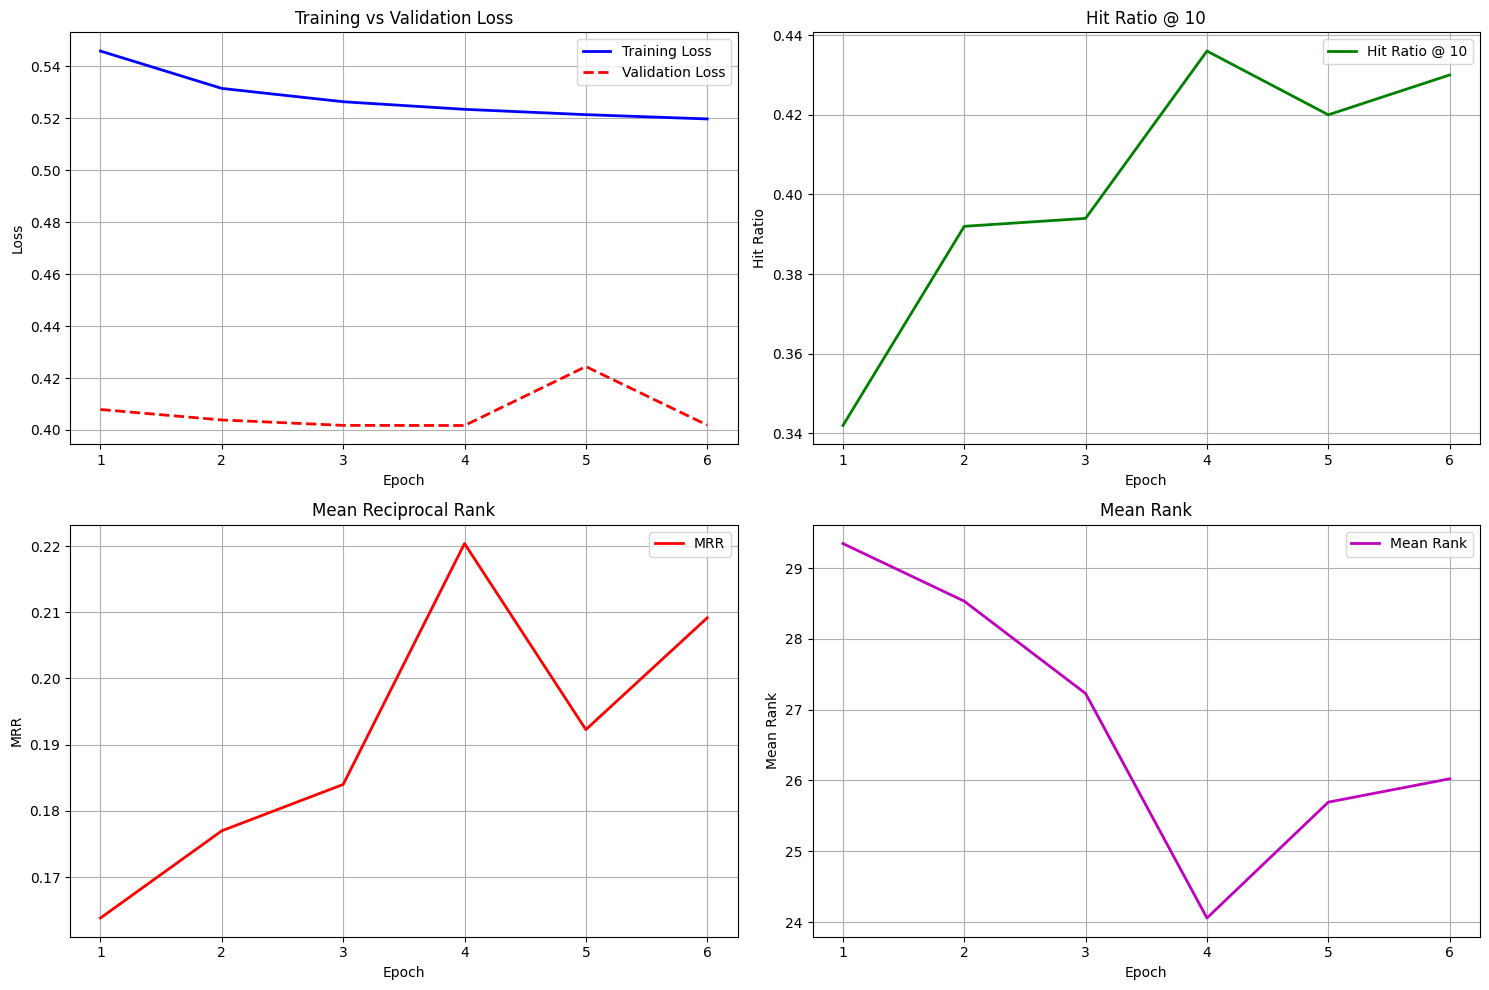

In [ ]:
trainer.plot_metrics(save_path="training_metrics.png")

In [ ]:

test_candidates = candidate_gen.precompute_validation_candidates(test_ratings, train_ratings, method="hybrid", num_candidates=100)

model.eval()
with torch.no_grad():
    print(f"Evaluating on test set...")
    test_hit_ratio, test_mrr, test_mean_rank = validate_model_with_features(
        model, test_ratings, test_candidates, device, 
        total_users_to_test=50, k=10
    )

print(f"TEST SET RESULTS:")
print(f"Hit Ratio @ 10: {test_hit_ratio:.3f}")
print(f"Mean Rank: {test_mean_rank:.1f}")
print(f"MRR: {test_mrr:.3f}")


Precomputing validation candidates for 6040 users...


Precomputing validation candidates:   0%|          | 0/6040 [00:00<?, ?it/s]

Precomputing validation candidates: 100%|██████████| 6040/6040 [00:34<00:00, 175.04it/s]


Precomputed validation candidates for 6040 users
Evaluating on test set...


Validating: 100%|██████████| 50/50 [00:01<00:00, 43.58it/s]

TEST SET RESULTS:
Hit Ratio @ 10: 0.400
Mean Rank: 28.1
MRR: 0.166


--

# COLD START PROBLEM SOLUTION

### Understanding the Cold Start Challenge

The **Cold Start Problem** is one of the most significant challenges in recommendation systems. It occurs when we need to make recommendations for:

- **New Users**: Users with no historical interaction data
- **New Items**: Items with no user ratings or interactions
- **New System**: Completely new recommendation system with minimal data

### Our Cold Start Strategy

Our implementation addresses the cold start problem through a sophisticated multi-layered approach:

- The flow depicts three complementary paths used for a new user: demographic‑based profiling, content‑based scoring from movie features, and popularity priors. The outputs are fused to produce initial recommendations; onboarding movies are selected to maximize genre diversity and information gain.

![Cold Start Strategy](images/cold_start.png)

### Technical Implementation

Our cold start solution leverages several advanced techniques:

#### 1. **Demographic-Based Recommendations**
- **User Profiling**: Age, gender, occupation, location analysis
- **Similarity Matching**: Find users with similar demographics
- **Preference Transfer**: Leverage preferences of similar user groups

#### 2. **Content-Based Filtering**
- **Movie Features**: Genre, title embeddings, metadata analysis
- **Popularity Signals**: Incorporate overall movie popularity
- **Hybrid Approach**: Combine multiple recommendation strategies

#### 3. **Strategic Onboarding**
- **Diverse Movie Selection**: Cover different genres and styles
- **Quick Preference Learning**: Efficiently discover user tastes
- **Minimal Friction**: Require minimal user effort for maximum information gain

### Cold Start Performance Metrics

| Scenario | Challenge | Our Solution | Expected Outcome |
|----------|-----------|--------------|------------------|
| **Pure Cold Start** | Zero user history | Demographic-based recommendations | Relevant suggestions based on user profile |
| **Onboarding Phase** | Discover preferences quickly | Strategically selected diverse movies | Rapid preference learning |
| **Warm Cold Start** | Limited interaction data | Combine demographics + sparse ratings | Improved recommendation accuracy |

### Demonstration Scenarios

We'll showcase three different cold start scenarios:

1. **Pure Cold Start**: New user with only demographic information
2. **Onboarding Movies**: Strategic movie selection for preference discovery  
3. **Warm Cold Start**: User with initial ratings on onboarding movies
4. **Demographic Comparison**: Different user profiles, different recommendations

Each scenario demonstrates how our system adapts to different levels of available user information.

---


## Load model

In [ ]:
# Demonstrate loading complete model using class method
print(f"\n4. LOADING COMPLETE MODEL (CLASS METHOD)")
print("-" * 50)

loaded_model = NCF.load_model(
    filepath="models/best_ncf_model.pth",
    ratings=train_ratings,
    feature_processor=feature_processor,
    precomputed_candidates=train_candidates,
    num_negatives=4
)



4. LOADING COMPLETE MODEL (CLASS METHOD)
--------------------------------------------------
Complete model loaded successfully from models/best_ncf_model.pth


In [178]:

# Initialize the cold start recommender with the trained model
cold_start_recommender = ColdStartRecommender(
    trained_model=loaded_model,
    feature_processor=feature_processor,
    candidate_generator=candidate_gen,
    movies_df=movies
)

print("Cold Start Recommender initialized successfully!")


Cold Start Recommender initialized successfully!


In [179]:
# DEMONSTRATION: Cold Start Recommendation Examples

print("="*80)
print("COLD START RECOMMENDATION SYSTEM DEMONSTRATION")
print("="*80)

# Example 1: Pure Cold Start - New user with only demographics
print("\n1. PURE COLD START SCENARIO")
print("-" * 50)

new_user_demographics = {
    'gender': 'M',     # Male
    'age': 25,         # 25 years old  
    'occupation': 4    # College/grad student (based on MovieLens occupation codes)
}

print(f"New User Demographics: {new_user_demographics}")

# Get recommendations without any ratings
cold_start_recommendations = cold_start_recommender.recommend_for_new_user(
    user_demographics=new_user_demographics,
    user_ratings=None,  # No ratings yet
    num_recommendations=10
)

print(f"\nTop 10 Cold Start Recommendations:")
for i, (movie_id, title, score) in enumerate(cold_start_recommendations, 1):
    print(f"{i:2d}. {title:<50} (Score: {score:.3f})")

# Example 2: Get onboarding movies for initial rating collection
print(f"\n\n2. ONBOARDING MOVIES FOR RATING COLLECTION")
print("-" * 50)

onboarding_movies = cold_start_recommender.get_onboarding_movies(num_movies=16)

print("Movies to show new user for initial ratings (diverse genres):")
for i, (movie_id, title, genres) in enumerate(onboarding_movies, 1):
    print(f"{i}. {title:<40} | Genres: {genres}")

# Example 3: Warm Cold Start - User has provided some initial ratings
print(f"\n\n3. WARM COLD START SCENARIO")
print("-" * 50)

# Simulate user rating some of the onboarding movies
initial_ratings = [
    (onboarding_movies[0][0], 5),  # Loved the first movie
    (onboarding_movies[1][0], 4),  # Liked the second movie
    (onboarding_movies[4][0], 4),  # Liked the fourth movie
    (onboarding_movies[5][0], 4),  # Liked the fourth movie
    (onboarding_movies[6][0], 4),  # Liked the fourth movie
    (onboarding_movies[7][0], 4),  # Liked the fourth movie
]

print("User's initial ratings:")
for movie_id, rating in initial_ratings:
    movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
    print(f"  {movie_title:<50} - Rating: {rating}/5")

# Get improved recommendations based on initial ratings
warm_recommendations = cold_start_recommender.recommend_for_new_user(
    user_demographics=new_user_demographics,
    user_ratings=initial_ratings,
    num_recommendations=10
)

print(f"\nTop 10 Recommendations after initial ratings:")
for i, (movie_id, title, score) in enumerate(warm_recommendations, 1):
    print(f"{i:2d}. {title:<50} (Score: {score:.3f})")

print(f"\n\n4. COMPARISON: Different User Demographics")
print("-" * 50)

# Example with different demographics
female_user_demographics = {
    'gender': 'F',     # Female
    'age': 45,         # 45 years old
    'occupation': 0    # Other/not specified
}

print(f"Different User Demographics: {female_user_demographics}")

female_recommendations = cold_start_recommender.recommend_for_new_user(
    user_demographics=female_user_demographics,
    user_ratings=None,
    num_recommendations=5
)

print(f"\nTop 5 Recommendations for different demographic:")
for i, (movie_id, title, score) in enumerate(female_recommendations, 1):
    print(f"{i}. {title:<50} (Score: {score:.3f})")

print(f"\n{'='*80}")
print("Cold Start Recommendation Demonstration Complete!")
print(f"{'='*80}")


COLD START RECOMMENDATION SYSTEM DEMONSTRATION

1. PURE COLD START SCENARIO
--------------------------------------------------
New User Demographics: {'gender': 'M', 'age': 25, 'occupation': 4}

Top 10 Cold Start Recommendations:
 1. Time to Kill, A (1996)                             (Score: 0.945)
 2. Beavis and Butt-head Do America (1996)             (Score: 0.937)
 3. Naked Gun: From the Files of Police Squad!, The (1988) (Score: 0.933)
 4. Secret Garden, The (1993)                          (Score: 0.933)
 5. Waiting to Exhale (1995)                           (Score: 0.932)
 6. City of Lost Children, The (1995)                  (Score: 0.932)
 7. Private Benjamin (1980)                            (Score: 0.931)
 8. Tarzan (1999)                                      (Score: 0.930)
 9. Ace Ventura: When Nature Calls (1995)              (Score: 0.927)
10. Rocky IV (1985)                                    (Score: 0.925)


2. ONBOARDING MOVIES FOR RATING COLLECTION
---------------------